# 환경 설정

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd

# 데이터셋 로드

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIFFEL_Research_6th/exp03_04_project/baseline_kernel/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIFFEL_Research_6th/exp03_04_project/baseline_kernel/data/test.csv')

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 데이터 전처리

In [5]:
y = train['price']
del train['price']
del train['zipcode']
del train['id']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']
del test['zipcode']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


# 타겟 분포 정규화

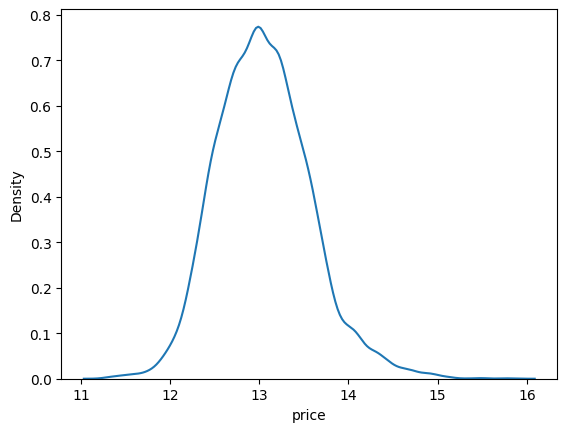

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y = np.log1p(y)
sns.kdeplot(y)
plt.show()

# 사용 함수 정의

In [9]:
# RMSE 계측

from sklearn.metrics import mean_squared_error

def calculate_rmse(y_test, y_pred):

    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [10]:
# 모델 훈련 및 점수 도출

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = calculate_rmse(y_test, y_pred)

    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

In [11]:
# 하이퍼 파라미터 조정 및 재훈련

from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # 1. GridSearchCV 모델로 model을 초기화합니다.
    grid_model = GridSearchCV(model, param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 2. 모델을 fitting 합니다.
    grid_model.fit(train, y)

    # 3. params, score에 각 조합에 대한 결과를 저장합니다.
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 results를 반환합니다.
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values(by='RMSLE')

    return results


In [12]:
# 제출용 파일 저장

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_Research_6th/exp03_04_project'
    submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIFFEL_Research_6th/exp03_04_project/baseline_kernel/data/sample_submission.csv')
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))


# 모델 생성 및 훈련

In [13]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2030

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]
get_scores(models, train, y)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2226
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 18
[LightGBM] [Info] Start training from score 13.048464


,RMSE
XGBRegressor,154507.031196
LGBMRegressor,153612.578153
GradientBoostingRegressor,151996.434932
RandomForestRegressor,149698.168923


# 하이퍼 파라미터 조정, 튜닝

In [14]:
# LGBMRegressor

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 10, 20]
}

model = LGBMRegressor(random_state=random_state)
results = my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 18
[LightGBM] [Info] Start training from score 13.048122


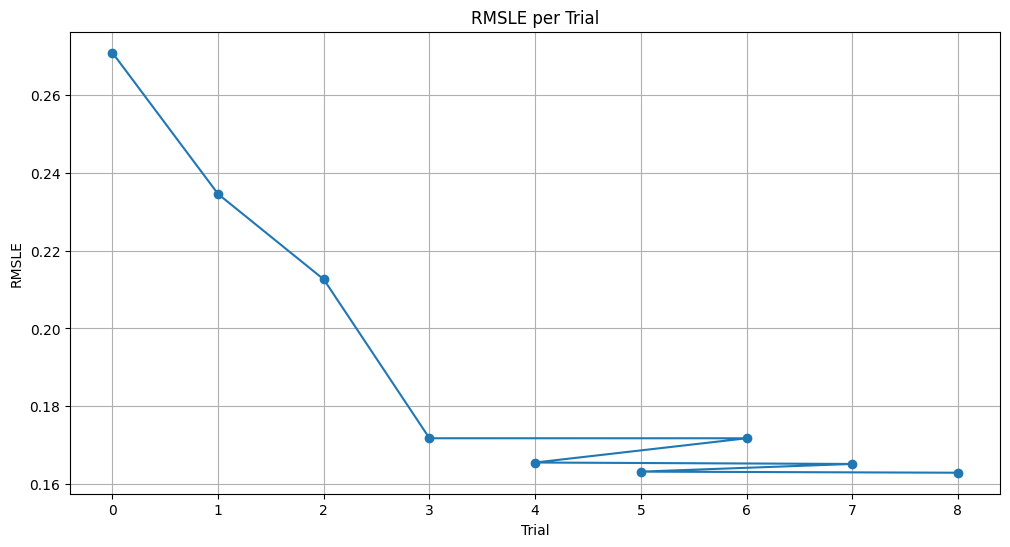

In [15]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['RMSLE'], marker='o')
plt.xlabel('Trial')
plt.ylabel('RMSLE')
plt.title('RMSLE per Trial')
plt.grid(True)
plt.show()


In [18]:
# RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20]
}

model = RandomForestRegressor(random_state=random_state)
results = my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


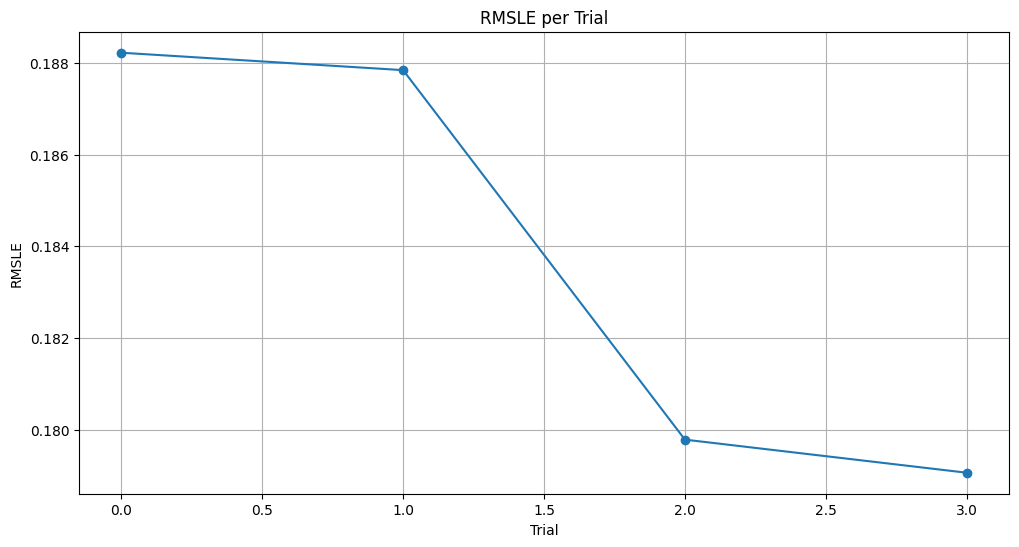

In [19]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['RMSLE'], marker='o')
plt.xlabel('Trial')
plt.ylabel('RMSLE')
plt.title('RMSLE per Trial')
plt.grid(True)
plt.show()


## 제출을 위한 파일 저장

In [20]:
save_submission(model, train, y, test, 'RFR', '149698')

/content/drive/MyDrive/Colab Notebooks/AIFFEL_Research_6th/exp03_04_project/submission_RFR_RMSLE_149698.csv saved!


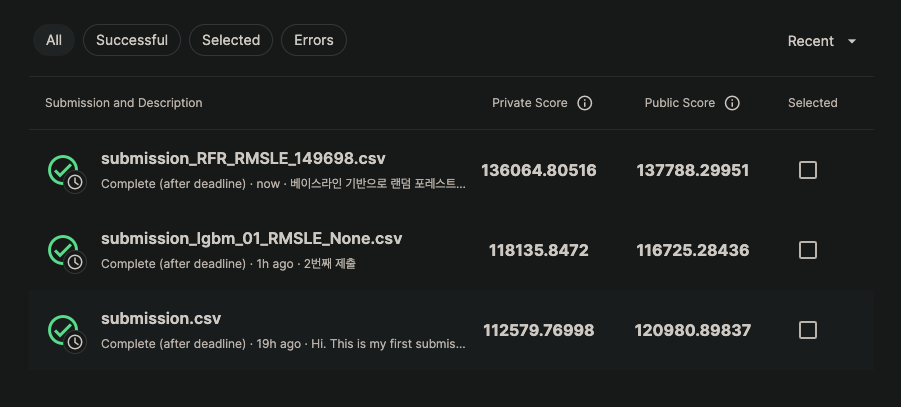